In [1]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class off_policy_MC:
    def __init__(self, file_path, index=None):
        track = pd.read_csv(file_path).values
        
        self.track = track
        self.q = np.random.rand(track.shape[0], track.shape[1], 5, 5, 9) * 10 - 20
        self.c = np.zeros((track.shape[0], track.shape[1], 5, 5, 9))
        self.actions = np.array([[i, j] for i in np.arange(-1, 2, 1) for j in np.arange(-1, 2, 1)])
        self.pi = np.argmax(self.q, axis = 4)
        if (index != None):
            self.pi[...] = index
        
    def policy_loop(self, num_iters, gamma=1, epsilon=0.1):
        start_ = time.time()
        sum_l = 1e-9
        sum_len = 1e-9
        # the big loop
        for num in range(num_iters):
            if (num % 5000 == 0):
                end_ = time.time()
                print(f"Big loop {num}: {round(num / num_iters * 100, 3)} %   cost {round(end_ - start_, 2)} s  used {round(sum_l / sum_len * 100, 3)} %")
                start_ = time.time()
                sum_l = 0
                sum_len = 0
            # random start point
            i, j = random.choice(np.argwhere(self.track == 1))
            v1, v2 = 0, 0
            s = []
            v = []
            prob = []
            # generate an episode
            while True:
                index = -1
                # epsilon-greedy 
                if np.random.choice([0, 1], p = [epsilon, 1 - epsilon]):
                    index = self.pi[i, j, v1, v2]
                else:
                    index = np.random.choice(9)
                # prob get
                if index == self.pi[i, j, v1, v2]:
                    prob.append(1 - epsilon + epsilon / 9)
                else:
                    prob.append(epsilon / 9)
                # delta speed in horizontal and vertical
                dv1, dv2 = self.actions[index]
                # add state
                s.append((i, j, v1, v2))
                v.append(index)
                # 0.1 possibility to get all zero
                if np.random.choice(10) == 0:
                    dv1, dv2 = 0, 0
                v1 = np.clip(v1 + dv1, 0, 4)
                v2 = np.clip(v2 + dv2, 0, 4)
                # collide condition
                field = self.track[max(0, i - v1) : i + 1, j : min(self.track.shape[1], j + v2 + 1)]
                # collide with destination
                if np.argwhere(field == 2).shape[0]:
                    break
                # collide with edge
                if  i - v1 < 0 or j + v2 > self.track.shape[1] or np.argwhere(field == -1).shape[0]:
                    i, j = random.choice(np.argwhere(self.track == 1))
                    v1, v2 = 0, 0
                    continue
                # normal state
                i = i - v1
                j = j + v2
                
            # count the reward
            g = 0
            w = 1
            l = len(s)
            while len(s):
                i, j, v1, v2 = s.pop()
                index = v.pop()
                p = prob.pop()
                state = (i, j, v1, v2, index)
                g = gamma * g - 1
                self.c[state] += w
                self.q[state] = self.q[state] + w / self.c[state] * (g - self.q[state])
                self.pi[i, j, v1, v2] = np.argmax(self.q[i, j, v1, v2, : ])
                if self.pi[i, j, v1, v2] != index:
                    break
                w = w / p
            sum_l += l - len(s)
            sum_len += l
        print("Done!")
        
    def show_policy(self, state=(0, 0), flag=True):
        if flag:
            i, j = random.choice(np.argwhere(self.track == 1))
        else:
            i ,j = state
        v1, v2 = 0, 0
        s = []
        v = []
        # generate an episode
        while True:
            index = self.pi[i, j, v1, v2]
            dv1, dv2 = self.actions[index]
            v1 = np.clip(v1 + dv1, 0, 4)
            v2 = np.clip(v2 + dv2, 0, 4)
            # add state
            s.append((i, j, v1, v2))
            v.append(index)
            # collide condition
            field = self.track[max(0, i - v1) : i + 1, j : min(self.track.shape[1], j + v2 + 1)]
            # collide with destination
            if np.argwhere(field == 2).shape[0]:
                print("successful!")
                break
            # collide with edge
            if  i - v1 < 0 or j + v2 > self.track.shape[1] or np.argwhere(field == -1).shape[0]:
                print("fail!")
                break
            # get struck
            if  v1 == 0 and v2 == 0 and dv1 < 1 and dv2 < 1:
                print("fail!")
                break
            # normal state
            i = i - v1
            j = j + v2
        
        x = np.zeros(self.track.shape)
        for _ in np.argwhere(mc.track == 0):
            i, j = _
            x[i, j] = 1
        for _ in np.argwhere(mc.track == 1):
            i, j = _
            x[i, j] = 2
        for _ in np.argwhere(mc.track == 2):
            i, j = _
            x[i, j] = 4
        for num in range(len(s)):
            i, j, _, _  = s[num]
            x[i, j] = 3

        plt.imshow(x, cmap='gray')

Big loop 0: 0.0 %   cost 0.0 s  used 100.0 %
Big loop 5000: 10.0 %   cost 15.12 s  used 10.853 %
Big loop 10000: 20.0 %   cost 6.87 s  used 22.435 %
Big loop 15000: 30.0 %   cost 6.22 s  used 24.032 %
Big loop 20000: 40.0 %   cost 6.43 s  used 22.779 %
Big loop 25000: 50.0 %   cost 5.79 s  used 24.467 %
Big loop 30000: 60.0 %   cost 5.5 s  used 25.384 %
Big loop 35000: 70.0 %   cost 5.34 s  used 25.975 %
Big loop 40000: 80.0 %   cost 5.11 s  used 26.763 %
Big loop 45000: 90.0 %   cost 5.01 s  used 27.267 %
Done!
successful!


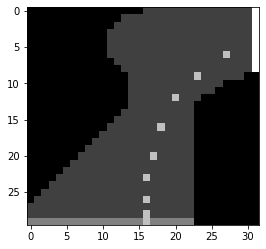

In [3]:
if __name__ == "__main__":
    mc = off_policy_MC("track2.csv", 8)
    mc.policy_loop(50000)
    mc.show_policy()
    
    # mc = off_policy_MC("track1.csv", 6)
    # mc.policy_loop(50000, epsilon=0.4)
    # mc.show_policy()